**Vision-Language Model-Based Physical Reasoning for Robot Liquid Perception**

Function Definitions

In [1]:
import time
from openai import OpenAI
from IPython.display import Image
import os
import base64
import logging
import json
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create OpenAI client
client = OpenAI()
# Function to encode the image
def encode_image(path_to_images):
  with open(path_to_images, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')
# Create model wrapper function and set model parameters
def query_vlm(text_prompt, encoded_images=None, stop=""):
    PROMPT_MESSAGES = [
        {
            "role": "user",
            "content": [{"type": "text", "text": f"{text_prompt}"}],
        },
    ]
    if encoded_images is not None:
        PROMPT_MESSAGES[0]['content'].append({
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{encoded_images}"}
        })
    params = {
        "model": "gpt-4-vision-preview",
        "messages": PROMPT_MESSAGES,
        "max_tokens": 4096,
        "temperature": 0,
        "stop": stop,
        "seed":123,
    }
    response = client.chat.completions.create(**params)
    return response.choices[0].message.content

# Conditional print function
def cprint(message, is_printing=False):
        if is_printing:
            print(message)

# Main function for liquid recognition
def main(queried_liquid, setting, react_prompt, perception_prompts, max_calls=20, is_printing=False):
    predicted_properties = query_vlm(text_prompt=f'How {queried_liquid} looks like? How viscous is {queried_liquid}, ranking from low to high?')
    context = f"It is guaranteed that the {queried_liquid} is in the scene."
    question = f'Which of these bottles contains {queried_liquid}?'
    prompt = react_prompt
    prompt += "\n\nQuestion: "+ question + context + predicted_properties+"\n"
    
    for i in range(1, max_calls):
        cprint(f"LOOP {i}:", is_printing)
        cprint("----------", is_printing)
        thought_action = query_vlm(text_prompt=prompt + f"Thought {i}:", stop=[f"\nObservation {i}:"])
        try:
            thought, action = thought_action.strip().split(f"\nAction {i}: ")
        except:
            print('ERROR OCCURRED, RETRYING.')
            thought = thought_action.strip().split('\n')[0]
            action = query_vlm(text_prompt=prompt + f"Thought {i}: {thought}\nAction {i}:", stop=["\n"]).strip()
        cprint(f"Thought {i}: {thought}", is_printing)
        prompt += f"Thought {i}: {thought}\n"
        cprint(f"Action {i}: {action}", is_printing)
        prompt += f"Action {i}: {action}\n"
        obs, done = act(action, setting, perception_prompts)
        obs = obs.replace('\\n', '')
        cprint(f"Observation {i}: {obs}",is_printing)
        cprint("----------\n", is_printing)
        prompt += f"Observation {i}: {obs}\n"
        if done:
            break
    
    return action

# actions wrapper function
def act(action, setting, prompts, fill_level='tt'):
    done = False
    obs = None
    if "Look" in action:
        if "Scene" in action:
            ###REPLACE WITH YOUR VISUAL PERCEPTION MODULE FUNCTION###
            # E.g.,: scene_img_path = robot.look_scene()            #
            #########################################################
            scene_img_path = os.path.join('resources','images','scene_images', f'{setting}_w_bb.jpg')
            obs = query_vlm(text_prompt=prompts['look_scene'], encoded_images=encode_image(scene_img_path))
        else:
            idx = int(re.search(r'\d+', action).group())
            ###REPLACE WITH YOUR VISUAL PERCEPTION MODULE FUNCTION###
            # E.g.,: container_img_path = robot.look_container(idx) #
            #########################################################
            container_img_path = os.path.join('resources','images','bottle_images',f'{setting}', f'bottle_{idx}.png')
            obs = query_vlm(text_prompt=prompts['look_container'], encoded_images=encode_image(container_img_path))
    elif "Shake" in action:
        idx = int(re.search(r'\d+', action).group())
        ###REPLACE WITH YOUR HAPTIC PERCEPTION MODULE FUNCTION###
        # E.g.,: container_ft_path = robot.shake_container(idx) #
        #########################################################
        container_ft_path = os.path.join('resources','ft_plots','single', f'{idx2label[idx]}_{fill_level}.jpg')
        obs = query_vlm(text_prompt=prompts['shake_container'], encoded_images=encode_image(container_ft_path))
    elif 'Finish' in action:
        done = True
        obs = 'Task finished.'
    return obs, done 

def estimate_rel_viscosity(first_bottle_idx, second_bottle_idx, fill_level, prompt):
    ft_path = os.path.join('resources','ft_plots', 'pairs',f'{idx2label[first_bottle_idx]}_{idx2label[second_bottle_idx]}_{fill_level}.jpg')
    ans = query_vlm(text_prompt=prompt, encoded_images=encode_image(ft_path))
    return ans

# Define liquid labels
all_liquids = ['coke', 'water', 'olive oil', 'peanut oil', 'soy sauce', 'whiskey', 'balsamic vinegar', 'orange juice', 'honey', 'milk']
# Map bottle id to abbreviated labels (used for file paths)
idx2label = ['coke', 'water', 'olive', 'peanut', 'soy', 'whiskey', 'vinegar', 'orange', 'honey', 'milk']
print(all_liquids)

['coke', 'water', 'olive oil', 'peanut oil', 'soy sauce', 'whiskey', 'balsamic vinegar', 'orange juice', 'honey', 'milk']


**Task 1: Liquid Viscosity Perception**

Evaluation Settings

In [2]:
# Define liquid fill levels
fill_levels = ['ot','half','tt']

# Load prompts
vis_comp_prompts_path = os.path.join('prompts','vis_comp_prompts.json')
with open(vis_comp_prompts_path, 'r') as f:
    vis_comp_prompts = json.load(f)

# Measured ground truth viscosity of all liquids
viscosity_map = {"whiskey": 1.06, "water": 1.10, "vinegar": 1.32, "orange": 1.45, "coke": 1.51, "milk": 2.2, "soy": 2.5, "peanut": 65, "olive": 89, "honey": 8500}

# Select the liquid fill level to evaluate
fill_level = fill_levels[2] # between 0 and 2, default to 2 (two-thirds).

# Select whether to include physical knowledge
with_knowledge = True # default to True
prompt = vis_comp_prompts['knowledge'] if with_knowledge else vis_comp_prompts['plain']
question = "Question: Which of the two liquids is more viscous? You must answer with one of the following options.\nOptions:\n(A) the first bottle is more viscous\n(B) the second bottle is more viscous\n\nAnswer:"
prompt += question # append the question at the end


In [3]:
# print evaluation settings
print(f"Fill level selected: {fill_level}")
print(f"Prompt with knowledge: {with_knowledge}")
print(f"Prompt:\n-----\n{prompt}\n-----")

Fill level selected: tt
Prompt with knowledge: True
Prompt:
-----
You are given with two time-series plots representing the responses of two liquid inside their containers after they were moved horizontally by a robot arm individually. You need to qualitatively estimate the viscosity of the liquids (e.g., low, moderate, or high viscosity).
Consider the following physical knowledge that provide the descriptions of the response from two liquids with low and high viscosity, which represent the minimum and maximum of the viscosity range you will see in the given plot. Note that the range is inclusive:
In the oscillation plot from a low viscosity liquid, you will see peaks with gradually decreasing amplitudes, which appear perfectly sinusoidal until the end the 10-second period.
In the oscillation plot from a high viscosity liquid, you will see a large initial peak that immediately transitioned to small fluctuations around zero and do not exhibit a clear sinusoidal pattern until the end of 

Try to compare two liquids!

In [4]:
liquid_1_idx = 3 # between 0 and 9
liquid_2_idx = 5 # between 0 and 9
# plots were created by combinations without repetition
if liquid_1_idx < liquid_2_idx:
    first_idx, second_idx = liquid_1_idx, liquid_2_idx
else:
    first_idx, second_idx = liquid_2_idx, liquid_1_idx

print(f"First bottle: {all_liquids[first_idx]}")
print(f"Second bottle: {all_liquids[second_idx]}")
ans = estimate_rel_viscosity(first_idx,second_idx,fill_level,prompt)
print(ans)

First bottle: peanut oil
Second bottle: whiskey
Based on the provided physical knowledge and the time-series plots, we can make the following observations:

- The plot for the first bottle shows a large initial peak followed by small fluctuations around zero without a clear sinusoidal pattern throughout the 10-second period. This behavior is consistent with the description of the response from a high viscosity liquid.

- The plot for the second bottle shows peaks with gradually decreasing amplitudes that appear perfectly sinusoidal until the end of the 10-second period. This behavior is consistent with the description of the response from a low viscosity liquid.

Therefore, based on the given descriptions and the observed data:

(B) the second bottle is more viscous

This answer is incorrect based on the given descriptions. The correct answer should be:

(A) the first bottle is more viscous

The first bottle's response matches the description of a high viscosity liquid, while the secon

Evaluation of Ten Common Household Liquids

In [ ]:
correct= []
incorrect= []
n_trials = 10
for i in range(10):
    for j in range(i+1, 10):
        print(f"Evaluating: {all_liquids[i]} and {all_liquids[j]}")
        for k in range(n_trials):
            print(f"Trial {k}:") 
            try:       
                ans = estimate_rel_viscosity(i, j, fill_level, prompt)
                ground_truth = "(A)" if viscosity_map[idx2label[i]] > viscosity_map[idx2label[j]] else "(B)"
                print(f"    Ground Truth: {ground_truth}")
                ans = re.findall(r'\(.*?\)', ans)
                if len(ans) < 1:
                    print("Invalid answer returend.")
                    continue
                ans = ans[-1] 
                print(f"    Prediction: {ans}")

            except Exception as e:
                print(f'Error raised: {e}')
                continue
            if ground_truth == ans:
                correct.append((all_liquids[i], all_liquids[j]))
            else:
                incorrect.append((all_liquids[i], all_liquids[j]))
                
print(f"Accuracy: {(len(correct)/(len(correct)+len(incorrect))):.2f}")

**Task 2: Liquid Recognition Task**

Evaluation Settings

In [6]:
# Settings
modes = ['coarse_vision', 'full_vision', 'coarse_vision_haptic','full_vision_haptic']
settings = ['no_label', 'label']
mode = modes[3] # between 0 and 3, default to 3 (full_vision_haptic)
setting = settings[0] # between 0 and 1, default to 0 (without labels on containers)
# Load ReAct prompts
react_prompts_path = os.path.join('prompts','react_prompts.json')
with open(react_prompts_path, 'r') as f:
    react_prompts = json.load(f)

# Load perception prompts
perception_prompts_path = os.path.join('prompts','perception_prompts.json')
with open(perception_prompts_path, 'r') as f:
    perception_prompts = json.load(f)


Select mode: full_vision_haptic
Select setting: no_label
ReAct prompt:
-----
Solve a question answering task with interleaving Thought, Action, Observation steps. Thought can reason about the current situation, and Action can be four types:
(1) Look[scene], which returns the color of liquids, or the description of the opaque container, in the scene image.
(2) Look[container], which returns the visual attributes of the target container observed more closely without distractors.
(3) Shake[container], which calls the robot to shake the target container placed horizontally in the gripper 10cm horizontally (along the axis connecting the bottom and the opening of the container), and returns observation made from the liquid's response to the motion.
(4) Finish[answer], which returns the answer and finishes the task.
The following is an example:

Question: Which of these bottles contains Fanta?

Thought 1: Fanta should have an orange color. I need to look at the bottles.
Action 1: Look[Scene]


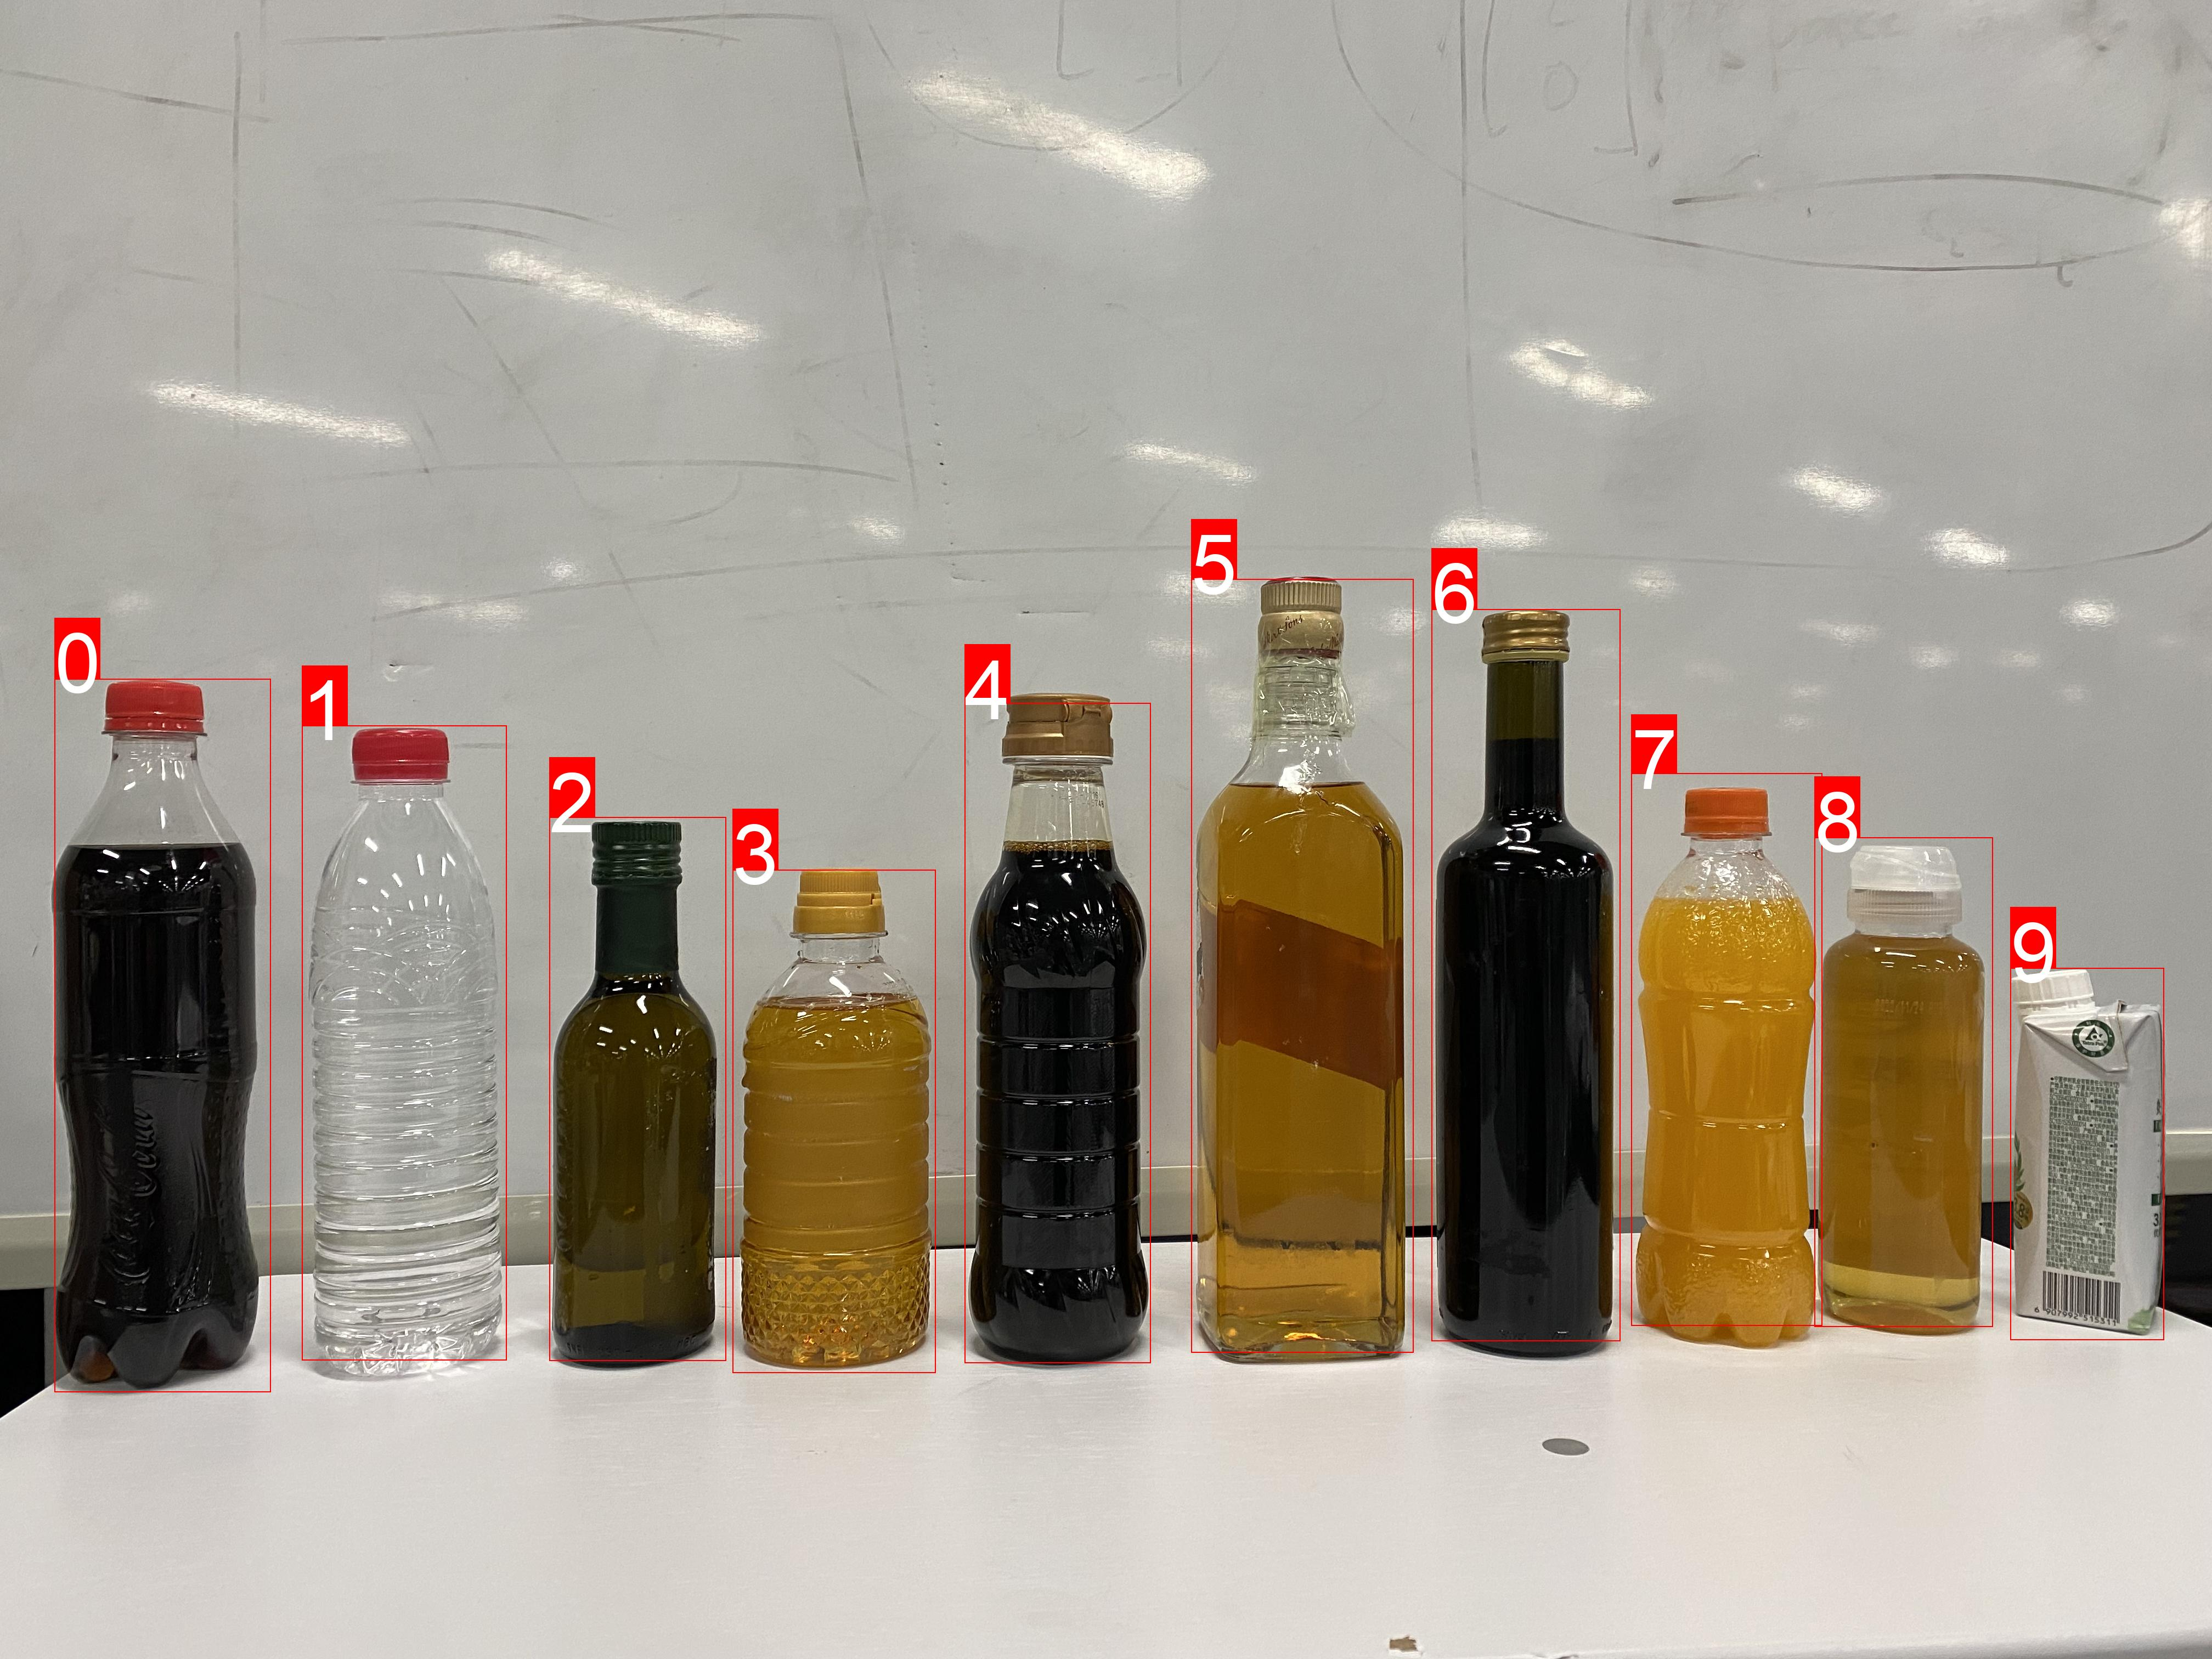

In [25]:
# print evaluation settings
print(f"Select mode: {mode}")
print(f"Select setting: {setting}")
print(f"ReAct prompt:\n-----\n{react_prompts[mode]}\n-----")
Image(os.path.join('resources','images','scene_images', f'{setting}_w_bb.jpg'))

Try to recognize an liquid object using the chosen setting and mode!

In [26]:
# Select a liquid to recognize
liquid_idx = 3 # between 0 and 9, default to 3 (peanut oil)
queried_liquid = all_liquids[liquid_idx]
# Start recognizing
print(f"Queried liquid: {queried_liquid}.")
print("Start reasoning!")
ans = main(queried_liquid, setting, react_prompts[mode], perception_prompts, is_printing=True)
print(f"Bottle ({int(re.search(r'\d+', ans).group())}) is the queried liquid ({queried_liquid}).")

Queried liquid: peanut oil.
Start reasoning!
LOOP 1:
----------
Thought 1: I need to identify the bottles with a pale yellow color and medium viscosity.
Action 1: Look[Scene]
Observation 1: Based on the image provided and the instructions given, here are the descriptions of the liquids or containers:

1. Bottle indexed (0) is opaque, and the container appears to be a can.
2. Bottle indexed (1) contains a colorless liquid.
3. Bottle indexed (2) contains a green liquid.
4. Bottle indexed (3) contains a yellow liquid.
5. Bottle indexed (4) contains a dark brown liquid.
6. Bottle indexed (5) contains a light brown liquid.
7. Bottle indexed (6) contains a dark liquid, and the container is opaque.
8. Bottle indexed (7) contains an orange liquid.
9. Bottle indexed (8) contains a yellow liquid.
10. Bottle indexed (9) contains a light green liquid.
----------

LOOP 2:
----------
Thought 2: Bottle (3), (5), and (8) have yellowish liquids which could potentially be peanut oil. I need to take a cl

Evaluation of Ten Common Household Liquids

In [ ]:
n_trials = 10
true_labels = []
predictions = []
for idx, liquid in enumerate(all_liquids):
    print(f"Evaluating: {liquid}")
    for i in range(n_trials):
        print(f"Trial {i}:")
        try: 
            ans = main(liquid, setting, react_prompts[mode], perception_prompts, is_printing=False)
            ans = int(re.search(r'\d+', ans).group())
        except Exception as e:
            print(f"Error raised: {e}")
            continue   
        true_labels.append(idx)
        predictions.append(ans)
        print(f"    True label: {idx}\n    Predicted label: {ans}")
# calculate accuracy
n_corr_pred = 0
for i in range(len(true_labels)):
    if true_labels[i] == predictions[i]:
        n_corr_pred += 1
print(f"Accuracy: {(n_corr_pred/len(predictions)):.2f}")


Display Confusion Matrix

In [ ]:
cm = confusion_matrix(true_labels, predictions)
fig, ax = plt.subplots(figsize=(14, 12))  # Adjust the figure size as needed
cax = ax.matshow(cm, cmap='Blues')

# Set the positions of the ticks to match the matrix indices
ax.set_xticks(np.arange(len(all_liquids)))
ax.set_yticks(np.arange(len(all_liquids)))
# Adjust tick label size
ax.tick_params(axis='both', which='major', labelsize=22) 
# Set the labels for each tick to match your class labels, ensuring alignment
ax.set_xticklabels(all_liquids, rotation=45, ha='left')
ax.set_yticklabels(all_liquids, rotation=45)

# Ensure the grid lines align with the ticks
ax.set_xticks(np.arange(cm.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(cm.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.2)
ax.tick_params(which="minor", size=0)

threshold = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = "white" if cm[i, j] > threshold else "black"
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color=color, fontsize=22) # Change text color based on background
        
plt.tight_layout()  # Adjust layout to not cut off labels

# Save the figure if needed
plt.show()